In [1]:
%load_ext autoreload
%autoreload 2 
# !apt-get install -y xvfb

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

## Data Loading

In [19]:
df = pd.read_csv(os.path.abspath("/home/sneha/airway_exploration/e5_cleaned_v1.csv"))

In [18]:
df.columns

Index(['idno', 'anatomicalname', 'centerlinelength', 'avginnerarea', 'lobe',
       'sublobe', 'endbpid', 'startbpid', 'angle', 'dircosx', 'dircosy',
       'dircosz', 'weibel_generation', 'v_'],
      dtype='object')

In [20]:
df['v_'] = pd.Series(df[['dircosx', 'dircosy', 'dircosz']].values.tolist())

df

,idno,anatomicalname,centerlinelength,avginnerarea,lobe,sublobe,endbpid,startbpid,angle,dircosx,dircosy,dircosz,weibel_generation,v_
0,3010007,Trachea,104.96200,351.51300,0.0,0.0,1.0,-1.0,NaN,-0.024446,0.229788,0.972934,0,"[-0.0244456, 0.229788, 0.972934]"
1,3010007,LMB,51.01420,148.68100,0.0,0.0,3.0,1.0,140.0360,0.608512,0.045926,0.792214,1,"[0.608512, 0.0459255, 0.792214]"
2,3010007,RMB,25.44420,215.56900,0.0,0.0,2.0,1.0,134.8050,-0.694225,-0.047878,0.718164,1,"[-0.694225, -0.0478776, 0.718164]"
3,3010007,BronInt,29.83190,111.98300,0.0,0.0,4.0,2.0,160.3120,-0.417837,0.018167,0.908341,2,"[-0.417837, 0.0181668, 0.908341]"
4,3010007,RUL,16.64940,75.69660,3.0,0.0,5.0,2.0,98.5825,-0.813123,-0.038720,-0.580802,2,"[-0.813123, -0.0387202, -0.580802]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926836,8024995,-,6.14524,6.48287,5.0,16.0,334.0,314.0,165.1320,0.164399,0.000000,0.986394,12,"[0.164399, 0.0, 0.986394]"
926837,8024995,-,15.64100,6.87548,5.0,19.0,335.0,317.0,156.6690,0.074125,0.667124,0.741249,12,"[0.0741249, 0.667124, 0.741249]"
926838,8024995,-,7.54570,6.98296,5.0,19.0,336.0,317.0,161.6230,0.205076,0.205076,0.957020,12,"[0.205076, 0.205076, 0.95702]"
926839,8024995,-,3.32710,5.57702,2.0,9.0,337.0,327.0,143.1220,-0.742781,-0.371391,0.557086,12,"[-0.742781, -0.371391, 0.557086]"


### TESTING

In [5]:
df_pilot = pd.read_csv(os.path.abspath("/home/sneha/airway_tree_pilot_clean.csv"))

In [6]:
df_full_pilot_filter = df.loc[df.idno.isin(df_pilot.idno.unique())][['idno', 'startbpid', 'endbpid', 'generation', 'segmentalgeneration']]

KeyError: "['generation', 'segmentalgeneration'] not in index"

In [ ]:
df_pilot_rel = df_pilot.copy()[['idno', 'startbpid', 'endbpid', 'generation', 'weibel_generation']]

In [ ]:
test_merge = df_pilot_rel.merge(df_full_pilot_filter, on=['idno', 'startbpid', 'endbpid'], how='left')
test_merge

In [ ]:
def _get_weibel_gen(participant_df):
    # groupby idno
    participant_df['new_weibel_gen'] =0
    groups = participant_df.groupby('idno')
    for name, group in tqdm(groups, desc='Iterating ids'):
#         print(name, group)
        start_end =  group[['startbpid', 'endbpid']].values
        keys_ = np.unique(start_end, return_counts=False)
        weibel_gen = dict.fromkeys(keys_, 0)
        weibel_gen[-1]=-1
    #     print(weibel_gen)
        for i in range(len(keys_)):
            key_test=keys_[i]
#             print('looking at key', key_test)
            # find children of this key
            children = group.loc[participant_df.startbpid==key_test]['endbpid'].values
#             print('children of key', children)
            for child in children:
                weibel_gen[child] = weibel_gen[key_test]+1
        participant_df.loc[participant_df.idno == name, 'new_weibel_gen'] = participant_df.loc[participant_df.idno == name, 'endbpid'].copy().map(weibel_gen)
    return participant_df
df_w_new = _get_weibel_gen(df.copy())

In [ ]:
df_w_new.rename(columns={'new_weibel_gen':'weibel_generation'}, inplace=True)

df_w_new.to_csv(os.path.abspath('/home/sneha/e5lungairwaysvida_20140211_weibel.csv'))

In [ ]:
(df_w_new.weibel_generation == df_w_new.new_weibel_gen).sum()/len(df_w_new)

### END TESTING


## Data Exploration 

### Segment Analysis

In [22]:


summary = df.groupby("idno").agg(
    {
        "anatomicalname":"count"
    }
).rename(
    columns = {
        "anatomicalname":"num_branch_segments"
    }
).sort_values(
    by="num_branch_segments",
    ascending=False
).describe().round(0).astype(int)
display(summary)
print(f"There are {summary.loc[summary.index=='count']['num_branch_segments'].item()} participants, each participant has on average {summary.loc[summary.index=='mean']['num_branch_segments'].item()} \pm {summary.loc[summary.index=='std']['num_branch_segments'].item()} branch segments")

,num_branch_segments
count,2911
mean,318
std,124
min,37
25%,233
50%,309
75%,393
max,991


There are 2911 participants, each participant has on average 318 \pm 124 branch segments


### Generation Analysis

In [23]:
print("Number of weibel generations per participant")

weibel = df.groupby("idno").agg(
    {
        "weibel_generation":["max", "mean"]
    }
)






new_cols = [first+"_"+second for (first, second) in weibel.columns]
weibel.columns = new_cols
weibel.describe().round().astype(int)

Number of weibel generations per participant


,weibel_generation_max,weibel_generation_mean
count,2911,2911
mean,13,7
std,2,1
min,6,4
25%,12,7
50%,13,7
75%,14,8
max,19,10


In [ ]:
# weibel gen vs gen labelled by vida --> from data dictionary Generation: This is not a useful variable, but is output by VIDA. It is a rough count of airway generation (trachea = 0), but it forces some anatomic airways to have specific values.

print(f"Discrepancy between the vida labelled generation vs the weibel_generation given in the df.\nVIDA: {df.generation.mean():.2f} \pm {df.generation.std():.2f}\nWEIBEL:{df.segmentalgeneration.mean():.2f} \pm {df.segmentalgeneration.std():.2f}  ")
df.plot.scatter(x="generation", y="segmentalgeneration")
plt.show()

In [ ]:
df.loc[df.segmentalgeneration == -1][['segmentalgeneration', 'generation']]

In [ ]:
# test for segmental generation vs weibel (load pilot data)
pilot = pd.read_csv('../airway_tree_pilot_clean.csv')
plt.scatter(pilot.generation, pilot.weibel_generation)

In [ ]:
pilot_ids = pilot.idno.unique()

filtered_df[['startbpid', 'endbpid', 'idno', 'dircosx', 'dircosy', 'dircosz', 'centerlinelength','segmentalgeneration']].head(), pilot.head()

### Label Analysis

830618 branch segments have empty entries in anatomicalname
8730 branch segments have the word 'unnamed' in their anatomicalname entry
There are 33 unique, valid anatomical names: ['BronInt', 'LB1', 'LB1+2', 'LB10', 'LB2', 'LB3', 'LB4', 'LB4+5', 'LB5', 'LB6', 'LB8', 'LB9', 'LLB', 'LLB6', 'LMB', 'LUL', 'RB1', 'RB10', 'RB2', 'RB2a', 'RB3', 'RB4', 'RB4+5', 'RB5', 'RB6', 'RB7', 'RB8', 'RB9', 'RLL', 'RLL7', 'RMB', 'RUL', 'Trachea']


Text(0, 0.5, '# segments')

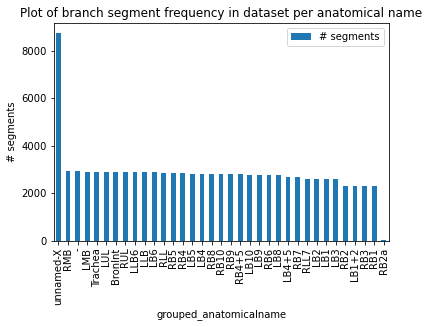

In [24]:
# what is unnamed vs just empty entry in the csv? is it checked vs unchecked?
print(f"{(df['anatomicalname']=='-').sum()} branch segments have empty entries in anatomicalname")
values, counts = np.unique(df.anatomicalname.dropna().astype(str), return_counts=True)
frequ_dict = dict(zip(values, counts))
unnamed = [v for k, v in frequ_dict.items() if 'unnamed' in k.lower()]
not_unnamed = [k for k in frequ_dict.keys() if (not 'unnamed' in k.lower()) and (k != '-')]
print(f"{sum(unnamed)} branch segments have the word 'unnamed' in their anatomicalname entry")
print(f"There are {len(not_unnamed)} unique, valid anatomical names: {not_unnamed}")
# ({df[~df['anatomicalname'].str.contains('unnamed')].anatomicalname.nunique()} unique types of valid label)") 
label_freq = df.groupby('anatomicalname').agg({'idno':'nunique'}).sort_values(by='idno', ascending=False).rename({"idno":"# segments"}, axis=1).reset_index()
label_freq["grouped_anatomicalname"] = label_freq.anatomicalname.apply(lambda x: x if 'unnamed' not in x else 'unnamed-X')
f, ax = plt.subplots()
label_freq[["grouped_anatomicalname","# segments"]].groupby("grouped_anatomicalname").agg("sum").reset_index().sort_values(by="# segments", ascending=False).plot.bar(x="grouped_anatomicalname", y="# segments", ax=ax)
plt.title("Plot of branch segment frequency in dataset per anatomical name")
plt.ylabel("# segments")


In [25]:
# for each named branch what % of patients have that branch
((df[
    ~(
        (df["anatomicalname"].str.lower().str.contains("unnamed"))| # filter dataframe to only look at normal labels
        (df["anatomicalname"]=="-")
    )
].groupby("anatomicalname").agg(
    {"idno":"count"} # check number of ids per name
)/df.idno.nunique())*100
).sort_values(
    by="idno",
    ascending=True
).reset_index().rename(
    {"idno":"% of patients that have this branch label"}, 
    axis=1
).round(2)

,anatomicalname,% of patients that have this branch label
0,RB2a,0.03
1,RB1,78.36
2,RB3,78.60
3,LB1+2,78.80
4,RB2,78.91
5,LB3,89.21
6,LB1,89.69
7,LB2,89.80
8,RLL7,89.80
9,RB7,91.89


In [11]:
print("All branches start at trachea and end on segment number 340\pm 132")
df.groupby("idno").agg({"startbpid":"min", "endbpid":max}).describe().round()

All branches start at trachea and end on segment number 340\pm 132


,startbpid,endbpid
count,2911.0,2911.0
mean,-1.0,340.0
std,0.0,132.0
min,-1.0,44.0
25%,-1.0,246.0
50%,-1.0,329.0
75%,-1.0,416.0
max,-1.0,1085.0


### Lobe Analysis

In [27]:
# branches per lobe, are there more labelled branches for some lobes?
def real_name(x):
    if x == "-":
        return "none"
    elif "unnamed-" in x:
        return "unnamed-X"
    else: 
        return "anatomical_label"

branches_per_lobe_df = df.copy().dropna()
branches_per_lobe_df["check_anatomicalname"] = branches_per_lobe_df["anatomicalname"].apply(lambda x: real_name(x))

# branches_per_lobe_df["realanatomicalname"] =0
# branches_per_lobe_df[ ~(
#         (branches_per_lobe_df["anatomicalname"].str.lower().str.contains("unnamed"))| # filter dataframe to only look at normal labels
#         (branches_per_lobe_df["anatomicalname"]=="-")
#     )]["realanatomicalname"] = 1
# branches_per_lobe_df.sort_values(by="realanatomicalname")
per_lobe_analysis = branches_per_lobe_df.groupby(
    [
        pd.Grouper("lobe"),
        pd.Grouper("check_anatomicalname")
    ]
).agg(
    {
        "idno":"count", 
        "angle": "mean",
        "centerlinelength":"mean",
        "weibel_generation":"max"
    })
per_lobe_analysis.rename(
    {
        "idno":"num_segments",
        "angle":"mean_branch_angle",
        "centerlinelength":"mean_branch_length",
        "weibel_generation":"max_weibel_generation"
    }, axis=1, inplace=True)
print("Looking at each lobe and splitting out whether the branch is labelled, has no label or is labeled unnamed-X")
display(per_lobe_analysis)
print("Aggregating at lobel level")
per_lobe = per_lobe_analysis.reset_index().groupby("lobe").agg({
    "num_segments":"sum", 
    "max_weibel_generation":"max",
"mean_branch_angle": ["mean", "std"],
"mean_branch_length":  ["mean", "std"]}).reset_index().sort_values(by=("num_segments", "sum"), ascending=True)
display(per_lobe)

Looking at each lobe and splitting out whether the branch is labelled, has no label or is labeled unnamed-X


num_segments  mean_branch_angle  \
lobe check_anatomicalname                                    
0.0  anatomical_label              8874         145.505909   
     none                          6390         142.826735   
     unnamed-X                      336         146.174632   
1.0  anatomical_label             21253         141.661888   
     none                        172750         142.633621   
     unnamed-X                     2123         150.130065   
2.0  anatomical_label             16966         149.970618   
     none                        192288         144.217140   
     unnamed-X                     1874         156.139343   
3.0  anatomical_label              9743         128.420115   
     none                        169832         142.347658   
     unnamed-X                      951         143.368900   
4.0  anatomical_label              8446         144.814239   
     none                         76398         145.714498   
     unnamed-X                      154         154.003666   
5.0  anatomical_label             19304         149.321681   
     none                        212920         144.049947   
     unnamed-X                     3291         156.387341   

                           mean_branch_length  max_weibel_generation  
lobe check_anatomicalname                                             
0.0  anatomical_label               33.441891                     11  
     none                            7.333266                     15  
     unnamed-X                       7.763429                     10  
1.0  anatomical_label               12.092548                      9  
     none                            9.496481                     16  
     unnamed-X                      10.712508                     10  
2.0  anatomical_label               12.431361                     10  
     none                           10.509011                     16  
     unnamed-X                      13.274707                     10  
3.0  anatomical_label               12.724135                     10  
     none                            9.177848                     16  
     unnamed-X                      10.354077                      9  
4.0  anatomical_label               14.102007                     11  
     none                           11.552150                     15  
     unnamed-X                      13.745778                     10  
5.0  anatomical_label               11.549133                     13  
     none                           10.795105                     19  
     unnamed-X                      13.697848                     13

Aggregating at lobel level


lobe num_segments max_weibel_generation mean_branch_angle            \
                sum                   max              mean       std   
0  0.0        15600                    15        144.835758  1.771703   
4  4.0        84998                    15        148.177468  5.065674   
3  3.0       180526                    16        138.045558  8.351503   
1  1.0       196126                    16        144.808525  4.634130   
2  2.0       211128                    16        150.109034  5.962307   
5  5.0       235515                    19        149.919657  6.190396   

  mean_branch_length             
                mean        std  
0          16.179528  14.951191  
4          13.133311   1.380862  
3          10.752020   1.806324  
1          10.767179   1.298897  
2          12.071693   1.417494  
5          12.014029   1.506179

In [ ]:
lobe_info = branches_per_lobe_df[["idno","lobe", "angle", "centerlinelength", "avginnerarea"]].head(100)#.groupby("lobe").agg(lambda x:x.to_list()).reset_index()
sns.pairplot(lobe_info, hue='lobe')
# sns.boxplot(x=branches_per_lobe_df["lobe"], y=branches_per_lobe_df["angle"])

### Branch Length Analysis

In [ ]:
branch_length_df = df[["idno", "segmentalgeneration", "centerlinelength"]].copy().groupby("segmentalgeneration").agg({"centerlinelength":"mean",
                                                                                       "idno":"nunique"}).rename({"idno":"num_patients", "centerlinelength":"mean_branch_length"}, axis=1)
f, ax= plt.subplots()
branch_length_df.reset_index().plot(x="segmentalgeneration", y="mean_branch_length", ax=ax)
plt.title("Variation in mean branch length with weibel generation") # NOTE NOT SURE ON UNITS

In [ ]:
# does this change lobe by lobe?

branch_length_per_lobe = df[["idno", "weibel_generation", "centerlinelength", "lobe"]].copy().groupby(
[
    pd.Grouper("lobe"),
    pd.Grouper("weibel_generation")
]).agg({"centerlinelength":["mean", "std"]}).reset_index()

display(branch_length_per_lobe)
colours = {"0":"blue",
          "1":"red",
          "2": "green",
          "3":"orange",
          "4": "purple",
          "5":"brown"}

fig,ax = plt.subplots()

for name in branch_length_per_lobe.lobe.unique():
    ax.errorbar(branch_length_per_lobe[branch_length_per_lobe.lobe==name]["segmentalgeneration"],
            branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","mean")],
            label=name, 
            yerr=branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","std")],
            capsize=3,
               elinewidth=1,
               color=colours[str(int(name))])

ax.set_xlabel("weibel_generation")
ax.set_ylabel("mean_centerlinelength")
ax.legend(loc='best')


fig,ax = plt.subplots()

for name in [x for x in branch_length_per_lobe.lobe.unique() if x != 0]:
    ax.errorbar(branch_length_per_lobe[branch_length_per_lobe.lobe==name]["segmentalgeneration"],
            branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","mean")],
            label=name, 
            yerr=branch_length_per_lobe[branch_length_per_lobe.lobe==name][("centerlinelength","std")],
            capsize=3,
            elinewidth=1,
            color=colours[str(int(name))]
            )

ax.set_xlabel("weibel_generation")
ax.set_ylabel("mean_centerlinelength")
ax.legend(loc='best')
ax.set_title("Removing the CEN 'lobe'")

### Angle Analysis

In [ ]:
# plot major vs minor branching angle, coloured by generation

per_bp = df.groupby([pd.Grouper('idno'),pd.Grouper('startbpid')]).agg({
    "angle":[min, max],
    "generation": min
}).reset_index().dropna()

per_bp.columns = ['idno', 'startbpid', 'min_angle', 'max_angle', 'generation']
per_bp = per_bp[per_bp.generation <= 13]

plt.figure()
plt.scatter(per_bp.min_angle, per_bp.max_angle, c=per_bp.generation,cmap='plasma', alpha=1)
plt.colorbar(label="generation", orientation="horizontal")
plt.xlabel("minor branching angle")
plt.ylabel("major branching angle")

plt.show()

# major-minor angle ratio
ratio = per_bp.max_angle / per_bp.min_angle
plt.figure()
plt.hist(ratio, bins=1000) # removing an outlier w ratio 35
plt.xlim(1,5)
plt.show()

In [ ]:
theta_ = np.arccos(df.dircosx.values)*180/np.pi
phi_ = np.arccos(df.dircosz.values)*180/np.pi

gen = df.generation.values
angle_df = pd.DataFrame({"gen":gen,"theta":theta_, "phi":phi_})
# angle_df.plot(x='gen', y='theta',linestyle='None', marker='o')
# plt.show()

In [ ]:
max_theta = np.max(theta_)
min_theta = np.min(theta_)
nbins = 20
bins = list(range(int(min_theta), int(max_theta)+1, nbins))
bins

In [ ]:
num_subplots = int(angle_df.gen.max())
f, axs = plt.subplots(int(num_subplots),2, figsize=(20,80))
for i in range(num_subplots):
    gen = i
    print(f"Num segments in generation {gen}: {len(angle_df.loc[angle_df.gen == gen])}")
    if gen == -1:
        print("Skipping Gen -1")
        continue
    ax = axs[i][0]
    ax.hist(angle_df.loc[angle_df.gen == gen].theta, bins=bins)
    ax.set_xlabel(f'Generation {gen}')
    ax.set_ylabel(f"Theta")
    ax.set_ylim(0,50000)
    ax2 = axs[i][1]
    ax2.hist(angle_df.loc[angle_df.gen == gen].phi, bins=bins)
    ax2.set_xlabel(f'Generation {gen}')
    ax2.set_ylabel(f"Phi")
    ax2.set_ylim(0,50000)


In [ ]:
# min branching angle vs max branching angle
df['theta_'] = np.arccos(df.dircosx.values)*180/np.pi
df['phi_'] = np.arccos(df.dircosz.values)*180/np.pi

gen = df.generation.values
angle_df = pd.DataFrame({'idno': df.idno.values,
                         "gen":gen,
                         "theta":theta_,
                         "phi":phi_, 
                        "angle": df.angle.values,
                        "startbpid": df.startbpid.values,
                        'endbpid': df.endbpid.values
                        })

per_branch_pt = angle_df.loc[(angle_df.startbpid != -1)&(angle_df.gen != -1)].groupby([pd.Grouper('idno'), pd.Grouper('startbpid')]).agg(['min', 'max']).reset_index()

In [ ]:
per_branch_pt.columns = [str(a)+"_"+str(b) for a,b in per_branch_pt.columns]


In [ ]:
per_branch_pt

In [ ]:
removing_mismatches = per_branch_pt[~(per_branch_pt.gen_min != per_branch_pt.gen_max)]

In [ ]:
removing_mismatches["ratio_theta"] = removing_mismatches.theta_min/removing_mismatches.theta_max
removing_mismatches["ratio_phi"] = removing_mismatches.phi_min/removing_mismatches.phi_max
f, axes = plt.subplots(15,1, figsize=(20,100))
for i in range(15):
    ax = axes[i]
    removing_mismatches.loc[removing_mismatches.gen_min == i].hist('ratio_theta', ax=ax)
    plt.show()

In [ ]:
f, axes = plt.subplots(15,2, figsize=(20,100))
for i in range(15):
    ax = axes[i][0]
    curr_gen = per_branch_pt.loc[per_branch_pt[('gen','min')] == i]
    ratio = curr_gen[('theta', 'max')]/curr_gen[('theta', 'min')]
    ax.hist(ratio.values)

### Caliber Analysis

count    826461.000000
mean         13.205087
std          27.138945
min           0.269678
25%           4.905950
50%           6.960530
75%          11.248000
max        2490.860000
Name: avginnerarea, dtype: float64

/tmp/ipykernel_17508/4077842405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outlier["log_radius"] = np.log2(np.sqrt(df_no_outlier["avginnerarea"]/np.pi))


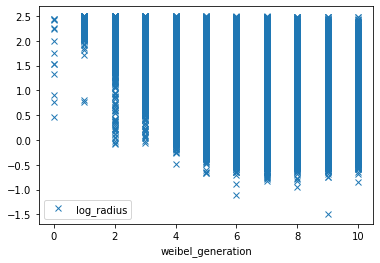

TypeError: hist() got multiple values for argument 'x'

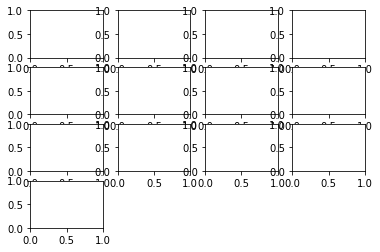

In [61]:
display(df[df.avginnerarea > 0].avginnerarea.describe())
# group by weibel dim then plot the histogram
# excluding 3 outliers above 500 CSA --> Question error?
df_no_outlier = df[(df.avginnerarea > 0) & (df.avginnerarea < 100) & (df.weibel_generation <=10)]
df_no_outlier["log_radius"] = np.log2(np.sqrt(df_no_outlier["avginnerarea"]/np.pi))
df_no_outlier.plot(y="log_radius", x="weibel_generation", style="x")
plt.show()

df_no_outlier.hist(x="weibel_generation", y="log_radius")

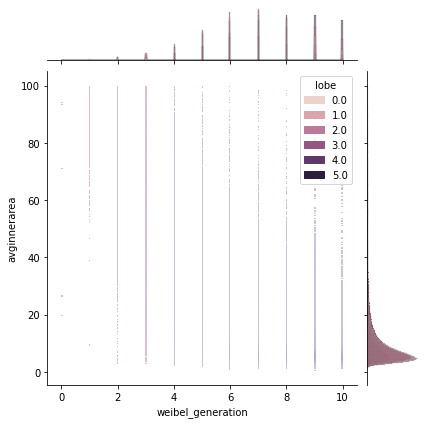

In [62]:
sns.jointplot(data=df_no_outlier,x="weibel_generation", y="avginnerarea", hue="lobe", kind="hist")
plt.show()

In [56]:
np.polyfit(x=df_no_outlier.weibel_generation.values, y= df_no_outlier.log_radius.values, deg=1) # outputs coeff of HIGHEST degree first
# not really woking --> could group by person, take avg per person per generation and tyr there maybe less noise?
# generate plots on the line


# regression = ols(x=df_no_outlier.weibel_generation, y=df_no_outlier.log_diameter)
# display(regression.summary) # slicing to only use last 30 points
# data = pd.DataFrame(index=x, data={'y': y, 'trend': trend})
# data.plot()

# df_no_outlier.plot(y="log_diameter", x="weibel_generation", style="x")


array([-0.17591945,  1.91088932])